In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-depression-dataset/Student Depression Dataset.csv


## Introduction

**Problem:** Depression among students is a pressing mental health challenge that impacts not only academic success but also personal well-being, and long-term life outcomes. There are several factors, such as academic pressure, sleep duration, financial stress, and family history of mental illness, that may contribute to depression, yet identifying at-risk students manually across large populations is impractical. Machine learning, therefore, offers a scalable solution to detect patterns and predict depression risk. This enables timely interventions by educators, counselors, and other support systems. 

**Objective:** This project aims to analyze a dataset of 27,901 students and build a machine learning model to predict depression status (Depression, 0 or 1) based on features like Academic Pressure, Sleep Duration, Financial Stress, CGPA, and Family History of Mental Illness. We will identify key drivers of depression and deliver a predictive tool through data exploration, preprocessing, and model evaluation.

**Approach**

In this project, we will:
1. Conduct Exploratory Data Analysis (EDA) to explore feature distributions and their relationships with Depression.
2. Preprocess the data (handle minimal missing values, encode categorical features, scale numerical ones).
4. Train classification models (e.g., Logistic Regression, Random Forest, XGBoost) to predict Depression.
5. Evaluate models with accuracy, precision, recall, and F1-score, addressing potential class imbalance.
6. Visualize results and interpret findings for actionable mental health insights.

## Import Libraries, Load Data

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [37]:
# load the data
df = pd.read_csv('/kaggle/input/student-depression-dataset/Student Depression Dataset.csv')
df.head()

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [38]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [39]:
# cofirm null values
df.isnull().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [40]:
# check for duplicates
df.duplicated().sum()

0

In [41]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


#### **Dataset Summary**

The student depression dataset contains 27,901 rows and 18 columns, detailing student demographics, academic factors, and mental health indicators:

- **Shape:** (27,901, 18) – A substantial dataset for robust analysis.
- **Target:** Depression (int64, 0 or 1, no missing values) – Binary classification target (0 = not depressed, 1 = depressed).
- **Key Features:**
    - **Numerical:**Age (float64, 18–59), CGPA (0–10), Work/Study Hours (0–12).
    - **Categorical (Ordinal):** Academic Pressure (0–5), Work Pressure (0–5), Study Satisfaction (0–5), Job Satisfaction (0–4), Financial Stress (1–5, 3 missing).
    - **Categorical (Nominal):** Gender (Male/Female), City, Profession (all Student), Sleep Duration (e.g., ‘5-6 hours’), Dietary Habits (e.g., Healthy), Degree (e.g., B.Pharm), Have you ever had suicidal thoughts? (Yes/No), Family History of Mental Illness (Yes/No).
- **Missing Values:** Only Financial Stress has 3 missing values (0.01%), minimal impact, we will impute it with .
- **Summary Stats:**
    - **Age:** Mean ~25.8, std ~4.9, range 18–59.
    - **CGPA:** Mean ~7.66, std ~1.47, range 0–10.
    - **Academic Pressure:** Mean ~3.14, std ~1.38, range 0–5.
    - **Financial Stress:** Mean ~3.14, std ~1.44, range 1–5.
    - **Depression:** Mean ~0.59 (58.5% depressed), std ~0.49, suggesting a slight majority with depression.
- **Notes:**
    - Dataset is nearly complete, with diverse features spanning academic, lifestyle, and mental health domains.
    - The high depression rate (58.5%) indicates a potentially skewed sample, worth exploring further.

## EDA

Exploratory Data Analysis is important because it reveals feature distributions, missing value patterns (though minimal), and relationships of othre features with Depression. This is important because understanding these distributions and relationships guides preprocessing and modeling, especially given the binary target and slight class skew.

**Approach**

1. Visualize distributions of numerical features (Academic Pressure, CGPA, Work/Study Hours, Financial Stress, Age).
2. Explore Depression distribution for class balance.
3. Analyze relationships between features and Depression using box plots and bar plots.
4. Check categorical feature distributions (e.g., Gender, Sleep Duration).

**Note:** I'll be treating Financial Stress, Job Satisfaction, Study Satisfaction and Academic Pressure as ordinal categorical features (1–5 scale)

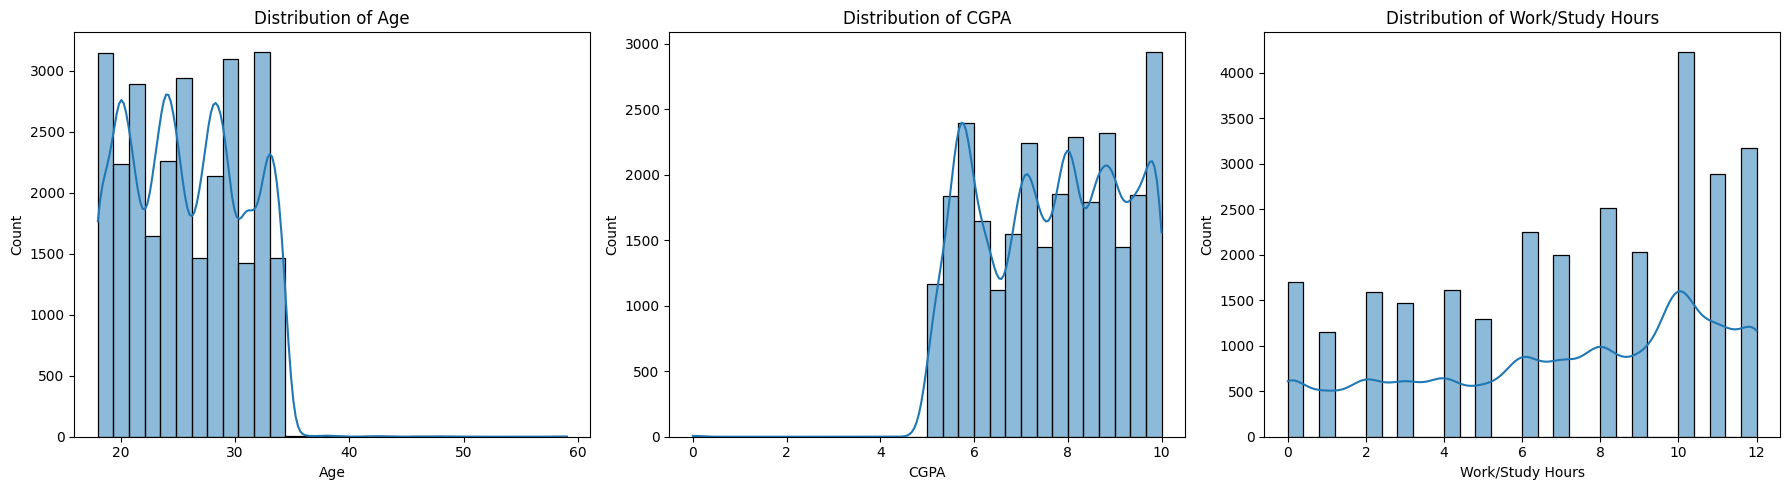

In [42]:
# Distribution of numerical features
numerical_cols = ['Age', 'CGPA', 'Work/Study Hours']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
plt.tight_layout()
plt.show()

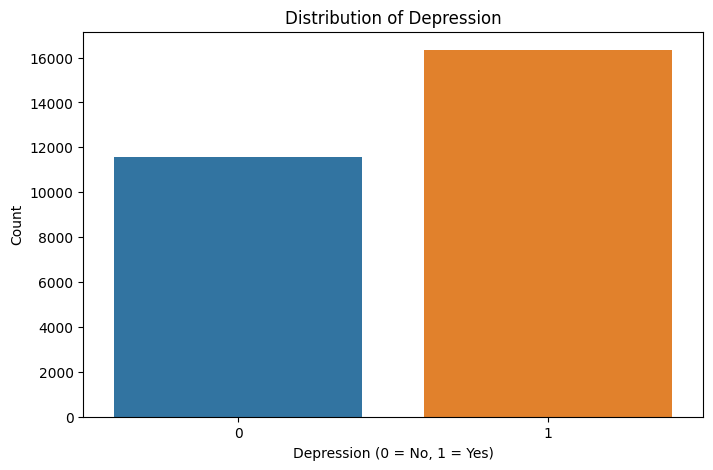

In [43]:
# Depression distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Depression')
plt.title('Distribution of Depression')
plt.xlabel('Depression (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

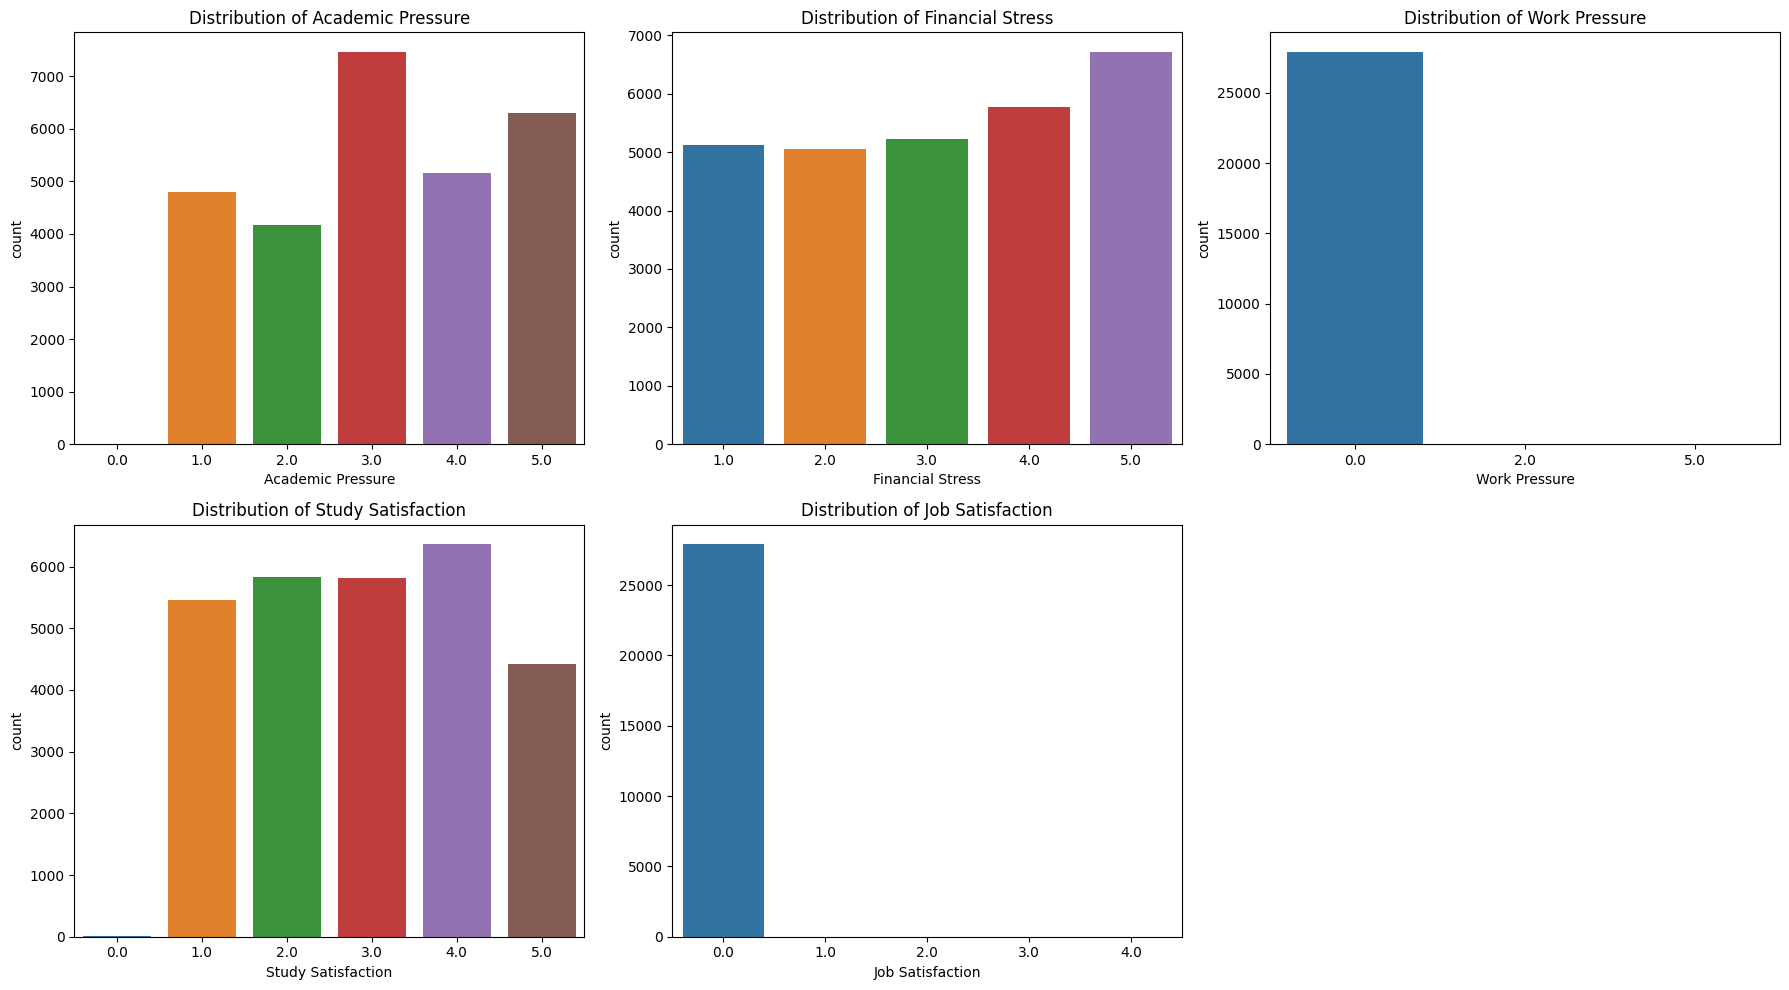

In [44]:
# Distribution of ordinal categorical features
categorical_cols = ['Academic Pressure', 'Financial Stress', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction']
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
axes[-1].axis('off')  # Hide extra subplot
plt.tight_layout()
plt.show()

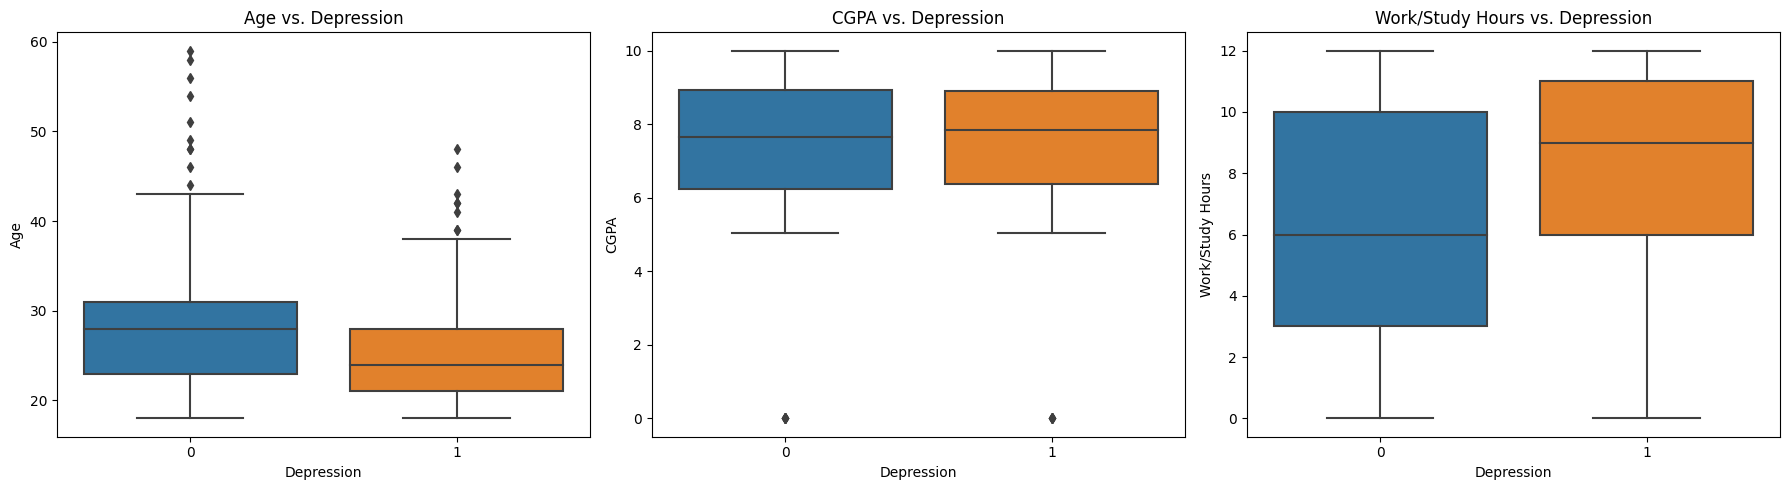

In [45]:
# Box plots of numerical features vs. Depression
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(numerical_cols):
    sns.boxplot(data=df, x='Depression', y=col, ax=axes[i])
    axes[i].set_title(f'{col} vs. Depression')
plt.tight_layout()
plt.show()

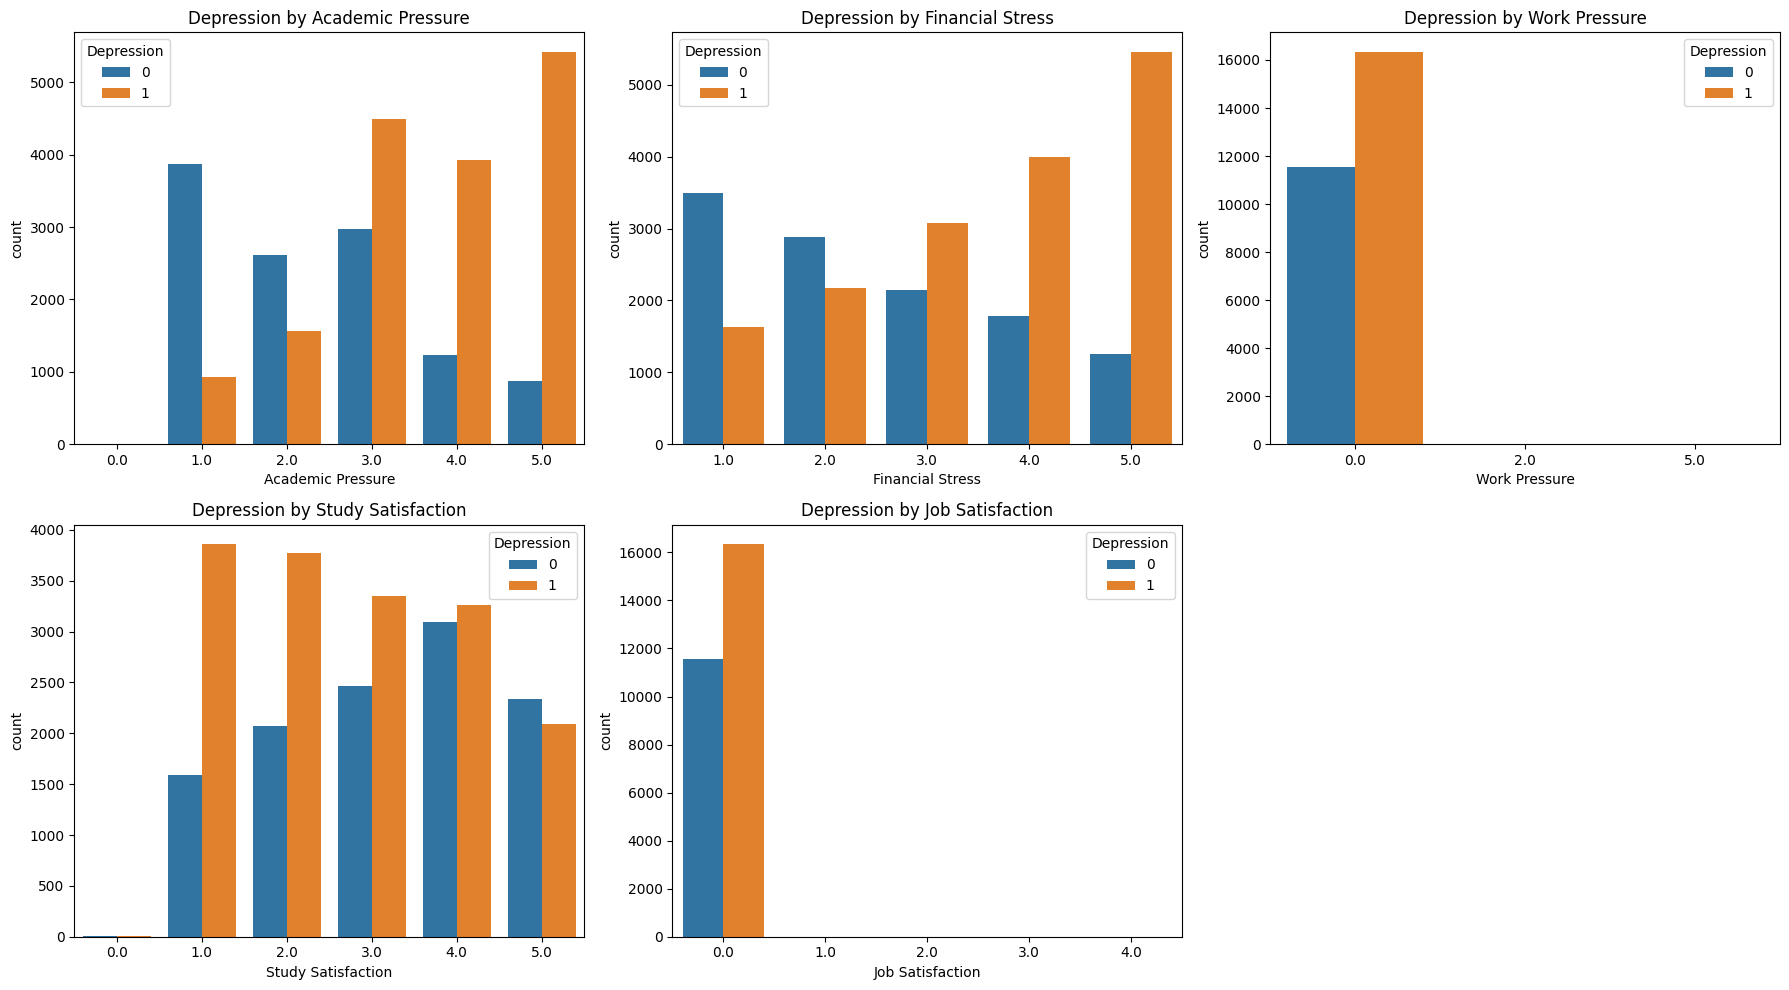

In [46]:
# Bar plots of ordinal categorical features vs. Depression
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue='Depression', ax=axes[i])
    axes[i].set_title(f'Depression by {col}')
    axes[i].set_xlabel(col)
axes[-1].axis('off')  # Hide extra subplot
plt.tight_layout()
plt.show()

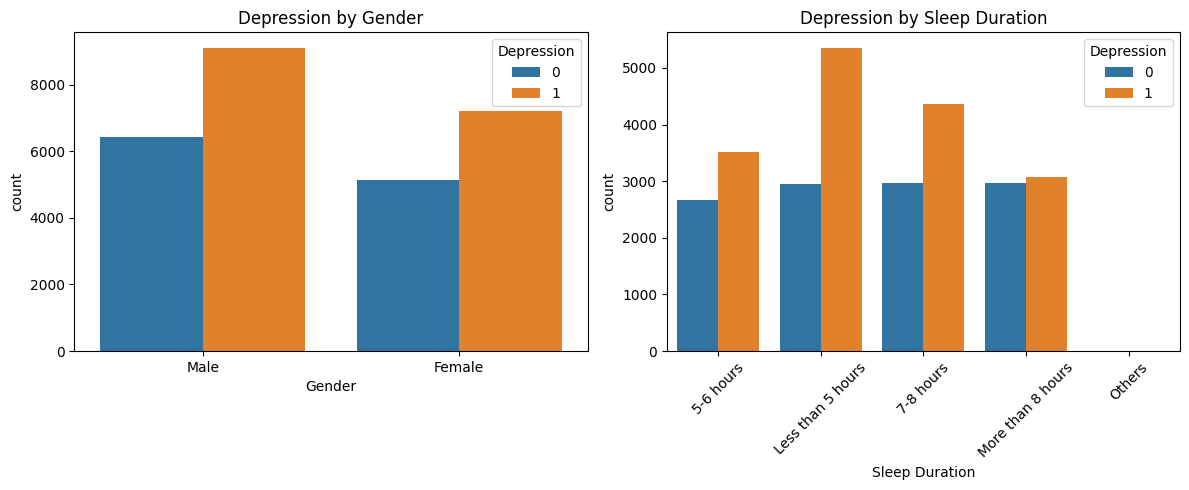

In [47]:
# Categorical feature distributions vs. Depression
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Gender', hue='Depression')
plt.title('Depression by Gender')
plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Sleep Duration', hue='Depression')
plt.title('Depression by Sleep Duration')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **Analysis of Results**

1. Numerical Feature Distributions:
    - **CGPA:** Left-skewed (mean ~7.66, std ~1.47, range 0–10), with most students at higher grades (e.g., 75% above 6.29), consistent with academic bias.
    - **Work/Study Hours:** Left-skewed (mean ~7.16, std ~3.71, range 0–12), many students at lower hours (e.g., 50% at 8 or below), with a tail of longer hours.
    - **Age:** Right-skewed (mean ~25.8, std ~4.9, range 18–59), most students young (e.g., 75% under 30), with older outliers.
    - **Observation:** Skewness in CGPA and Work/Study Hours suggests potential transformation needs; Age’s outliers may require robust scaling.
2. Ordinal Categorical Feature Distributions:
    - **Financial Stress:** Highest at 5, then 4, 3, 2, 1 (mean ~3.14), indicating prevalent high stress (5 most common).
    - **Academic Pressure:** Highest at 3, then 5, 4, 1, 2 (mean ~3.14), roughly normal with a peak at moderate pressure (3).
    - **Work Pressure:** All at 0.0 (mean ~0.0004, range 0–5), suggesting no variability—likely all students (no workers) report zero work pressure.
    - **Job Satisfaction:** All at 0.0 (mean ~0.0007, range 0–4), similarly uniform, reflecting students’ lack of job context.
    - **Study Satisfaction:** Highest at 4, then 3, 2, 1, 5 (mean ~2.94), skewed toward higher satisfaction (4 most common).
    - **Observation:** Work Pressure and Job Satisfaction lack variation (all 0), making them uninformative. Financial Stress and Academic Pressure show meaningful spread; Study Satisfaction leans positive.
3. Depression Distribution:
    - **Pattern:** Higher count of 1’s (~58.5%, ~16,332) vs. 0’s (~41.5%, ~11,569), confirming a slight majority of depressed students.
    - **Observation:** Near-balanced but skewed toward depression, manageable without heavy oversampling.
4. Box Plots (Numerical Features vs. Depression):
    - **CGPA:** Equal metrics for 0’s and 1’s (mean ~7.66, similar IQR), no clear depression link despite skew.
    - **Work/Study Hours:** 0’s have higher IQR (wider spread) but lower mean (~6.5) vs. 1’s (~7.5), indicating non-depressed students vary more but study less, depressed students slightly more consistently.
    - **Age:** Many outliers (older students), no noted mean/IQR difference, suggesting minimal depression impact.
Observation: Work/Study Hours shows a subtle trend; CGPA and Age are weak predictors.
5. Bar Plots (Ordinal Categorical Features vs. Depression):
    - **Financial Stress:** Decreasing 0’s, increasing 1’s from 1 to 5 (e.g., 1: more 0’s; 5: more 1’s), a strong trend linking higher stress to depression.
    - **Academic Pressure:** Decreasing 0’s, increasing 1’s from 1 to 5 (e.g., 1: more 0’s; 5: more 1’s), a strong trend linking higher stress to depression.
    - **Work Pressure:** All 0, no variation to analyze.
    - **Job Satisfaction:** All 0, no variation.
    - **Study Satisfaction:** Increasing 0's, decreasing 1's with more 0’s, lower (e.g., 1) with 1’s.
    - **Observation:** Financial Stress and job satisfation are standout predictors; Work Pressure and Job Satisfaction add no value.
6. Bar Plots (Nominal Categorical Features vs. Depression):
    - **Gender:** Higher counts for males in both 0’s and 1’s, suggesting males dominate the sample (~50%+), with similar depression rates.
    - **Sleep Duration:** Highest 1’s at “Less than 5 hours,” then “7-8 hours,” “5-6 hours,” lowest at “More than 8 hours” (equal 0’s and 1’s). Short sleep (<5 hours) strongly ties to depression.
    - **Observation:** Sleep Duration is a key driver; Gender shows no clear disparity.

**Insights**

- **Key Predictors:** Financial Stress (higher → more depression) and study satisfaction (lower - more depression), Sleep Duration (<5 hours → highest depression), and mildly Academic Pressure and Work/Study Hours.
- **Weak Features:** CGPA, Age, Work Pressure, Job Satisfaction (latter two all 0) lack differentiation.
- **Class Balance:** Slight skew (58.5% depressed) suggests mild imbalance.
- **Actionable:** Drop Work Pressure and Job Satisfaction (no variance); focus on Financial Stress, study satisfaction and Sleep Duration.

## Preprocessing 

Preprocessing prepares the dataset by removing uninformative features, imputing minimal missing values, encoding categorical variables, and scaling numerical ones, ensuring a robust feature set for predicting Depression.

**Methods**

1. Drop id, Work Pressure, Job Satisfaction (no variance), City, and Degree (high cardinality).
2. Impute Financial Stress (3 missing) with mode (likely 5).
3. Keep Financial Stress, Academic Pressure, Study Satisfaction as ordinal numerical features (no encoding).
4. Encode categorical features (Gender, Profession, Sleep Duration, Dietary Habits, Have you ever had suicidal thoughts?, Family History of Mental Illness) with one-hot encoding.
5. Scale numerical features (Age, CGPA, Work/Study Hours, Financial Stress, Academic Pressure, Study Satisfaction) with StandardScaler.
6. Split into features (X) and target (y).

In [48]:
# Drop uninformative columns
df_clean = df.drop(columns=['id', 'Work Pressure', 'Job Satisfaction'])
print("Shape after dropping columns:", df_clean.shape)

Shape after dropping columns: (27901, 15)


In [49]:
# Impute missing Financial Stress with mode
df_clean['Financial Stress'] = df_clean['Financial Stress'].fillna(df_clean['Financial Stress'].mode()[0])
print("\nMissing Values After Imputation:")
print(df_clean.isnull().sum())


Missing Values After Imputation:
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
CGPA                                     0
Study Satisfaction                       0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


In [51]:
# Define numerical and categorical columns
numerical_cols = ['Age', 'CGPA', 'Work/Study Hours', 'Financial Stress', 'Academic Pressure', 'Study Satisfaction']
categorical_cols = ['Gender', 'Profession', 'Sleep Duration', 'Dietary Habits', 
                    'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

In [52]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),          # Scale numerical features
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)  # Encode categorical
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

In [53]:
# Get feature names after encoding
cat_encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_encoded_cols)
X_processed_df = pd.DataFrame(X_processed, columns=feature_names)

# Check processed data
print("Processed Features Shape:", X_processed_df.shape)
print("\nProcessed Features Info:")
print(X_processed_df.info())
print("\nFirst 5 Rows:")
print(X_processed_df.head())

Processed Features Shape: (27901, 29)

Processed Features Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        27901 non-null  float64
 1   CGPA                                       27901 non-null  float64
 2   Work/Study Hours                           27901 non-null  float64
 3   Financial Stress                           27901 non-null  float64
 4   Academic Pressure                          27901 non-null  float64
 5   Study Satisfaction                         27901 non-null  float64
 6   Gender_Male                                27901 non-null  float64
 7   Profession_Chef                            27901 non-null  float64
 8   Profession_Civil Engineer                  27901 non-null  float64
 9   Profession_Content Writer     

## Model Selection and Training

In [55]:
# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42, stratify=y)
print("Training Shape:", X_train.shape)
print("Testing Shape:", X_test.shape)

Training Shape: (22320, 29)
Testing Shape: (5581, 29)


In [56]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


Logistic Regression Results:
               precision    recall  f1-score   support

Not Depressed       0.82      0.79      0.81      2313
    Depressed       0.86      0.88      0.87      3268

     accuracy                           0.84      5581
    macro avg       0.84      0.84      0.84      5581
 weighted avg       0.84      0.84      0.84      5581



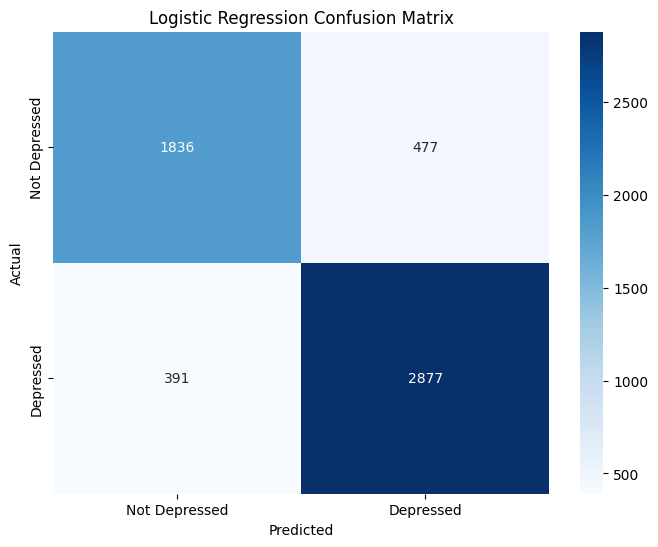


Random Forest Results:
               precision    recall  f1-score   support

Not Depressed       0.81      0.78      0.79      2313
    Depressed       0.85      0.87      0.86      3268

     accuracy                           0.83      5581
    macro avg       0.83      0.82      0.83      5581
 weighted avg       0.83      0.83      0.83      5581



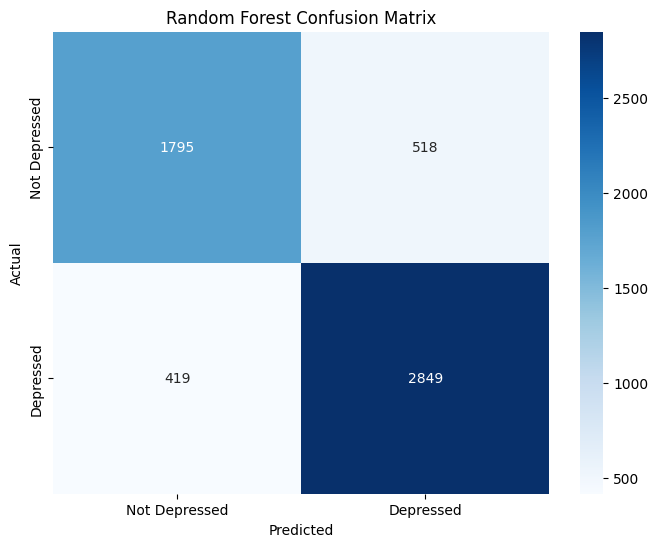


XGBoost Results:
               precision    recall  f1-score   support

Not Depressed       0.82      0.78      0.80      2313
    Depressed       0.85      0.88      0.86      3268

     accuracy                           0.84      5581
    macro avg       0.83      0.83      0.83      5581
 weighted avg       0.84      0.84      0.84      5581



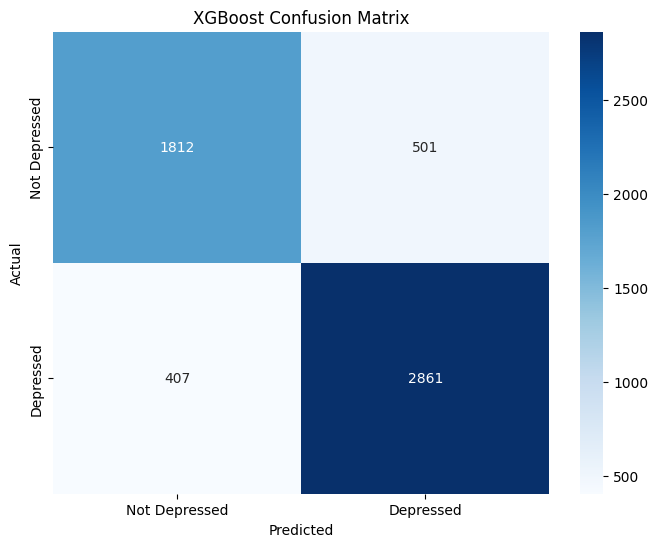

In [57]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred, target_names=['Not Depressed', 'Depressed']))
    cm = confusion_matrix(y_test, y_pred)
    results[name] = {'y_pred': y_pred, 'cm': cm}
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Depressed', 'Depressed'], 
                yticklabels=['Not Depressed', 'Depressed'])
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

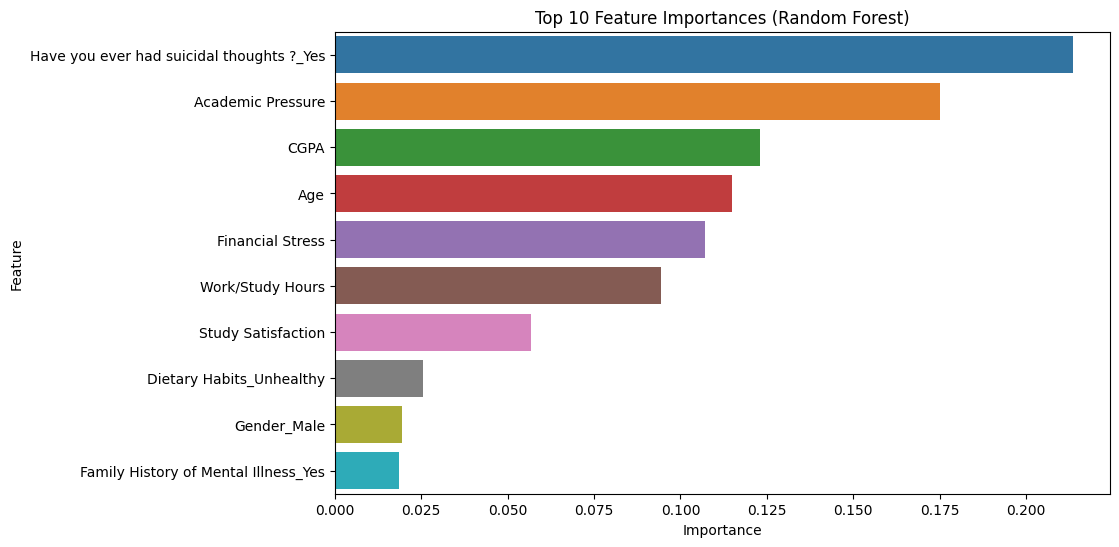

In [58]:
# Feature Importance (Random Forest)
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_processed_df.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

#### **Analysis of Results**
1. Logistic Regression:
    - **Metrics:**
        - **Accuracy:** 0.84
        - **Not Depressed:** Precision 0.82, Recall 0.79, F1 0.81
        - **Depressed:** Precision 0.86, Recall 0.88, F1 0.87
        - **Macro Avg:** Precision 0.84, Recall 0.84, F1 0.84
    - **Confusion Matrix:** TP=2,877, FP=477, FN=391, TN=1,836
        - **True Positives (Depressed correct):** 2,877/3,268 = 88% recall.
        - **False Negatives (Depressed missed):** 391, good sensitivity.
        - **True Negatives (Not Depressed correct):** 1,836/2,313 = 79% recall.
    - **Interpretation:** Strong performance, slightly favoring Depressed class (higher recall), leveraging linear relationships.
2. Random Forest:
    - **Metrics:**
        - **Accuracy:** 0.83
        - **Not Depressed:** Precision 0.81, Recall 0.78, F1 0.79
        - **Depressed:** Precision 0.85, Recall 0.87, F1 0.86
        - **Macro Avg:** Precision 0.83, Recall 0.82, F1 0.83
    - **Confusion Matrix:** TP=2,849, FP=518, FN=419, TN=1,795
        - **TP:** 2,849/3,268 = 87% recall.
        - **FN:** 419, slightly more misses than Logistic Regression.
        - **TN:** 1,795/2,313 = 78% recall.
    - **Interpretation:** Slightly lower accuracy (0.83 vs. 0.84), but robust, with balanced precision/recall.
3. XGBoost:
    - **Metrics:**
        - **Accuracy:** 0.84
        - **Not Depressed:** Precision 0.82, Recall 0.78, F1 0.80
        - **Depressed:** Precision 0.85, Recall 0.88, F1 0.86
        - **Macro Avg:** Precision 0.83, Recall 0.83, F1 0.83
    - **Confusion Matrix:** TP=2,861, FP=501, FN=407, TN=1,812
        - **TP:** 2,861/3,268 = 88% recall.
        - **TN:** 1,812/2,313 = 78% recall.
    - **Interpretation:** Matches Logistic Regression’s accuracy (0.84), with strong Depressed class prediction.
4. **Random Forest Feature Importannce:** Suicidal Thoughts dominates, aligning with mental health intuition. Academic Pressure and Financial Stress confirm EDA trends (higher values → more depression). CGPA and Age ranking high is surprising given weak EDA signals, suggesting model-specific interactions.

**Insights**
- **Performance:** All models achieve strong accuracy (0.83–0.84) and F1-scores (0.79–0.87), well above the baseline of 0.585 (majority class), indicating good predictive power. Logistic Regression and XGBoost edge out Random Forest slightly (0.84 vs. 0.83).
- **Class Balance:** Mild imbalance (58.5% Depressed) handled well, with recall favoring Depressed (87–88%) over Not Depressed (78–79%), reflecting higher sensitivity to the positive class—critical for depression detection.
- **Key Predictors**: Suicidal Thoughts, Academic Pressure, and Financial Stress align with EDA (Sleep Duration_<5 hours likely in top 10, not listed). CGPA and Age’s prominence suggests nuanced effects in ensemble models.
- **Confusion Matrices:** Low false negatives (391–419) ensure few depressed students are missed, vital for intervention.

## Conclusion

This project analyzed a dataset of 27,901 students to predict Depression (58.5% prevalence) using 29 features:

- EDA: Identified Financial Stress, Sleep Duration, and Academic Pressure as key depression drivers; CGPA and Age showed weaker links.
- Preprocessing: Streamlined from 18 to 29 features, dropping high-cardinality (City, Degree) and uninformative (Work Pressure, Job Satisfaction) columns, scaling ordinal and continuous features.
- Modeling: Achieved 0.83–0.84 accuracy, with Logistic Regression and XGBoost excelling, driven by Suicidal Thoughts, Academic Pressure, and Financial Stress.
- The evaluation shows all three models effectively predict Depression, with Logistic Regression and XGBoost achieving the highest accuracy (0.84) and balanced F1-scores (0.84–0.87). Random Forest (0.83) provides valuable feature insights, highlighting Suicidal Thoughts, Academic Pressure, and Financial Stress as top drivers, consistent with EDA. The 29-feature set, reduced from 118, strikes a good balance, though Profession’s unexpected diversity (12 cols) may warrant dropping if all are Students. Logistic Regression is recommended for simplicity and performance, with potential for further tuning (e.g., class weights) or feature selection to enhance results.